# Julia packages

In [ ]:
import Pkg
Pkg.add("Gen")
Pkg.add("Plots")
Pkg.add("StatsBase")
Pkg.add("StatsPlots")
Pkg.add("Distributions")
#Pkg.add("Luxor")

In [ ]:
#import Random, Logging
using Gen, Plots, Distributions, StatsPlots
using StatsBase: mean, countmap

# RSA model: Politeness

## The case study of white lies

### L0

In [ ]:
# Define state and utterance space

states = [1, 2, 3, 4, 5]
stateProbs = [0.2, 0.2, 0.2, 0.2, 0.2]
utterances = ["terrible", "bad", "okay", "good", "amazing"]
utterancesProbs = [0.2, 0.2, 0.2, 0.2, 0.2]
key_mapping = Dict("terrible" => 1, "bad" => 2, "okay" => 3, "good" => 4, "amazing" => 5)

# Literal semantics represented as probabilities
literalSemantics = Dict(
    "terrible" => [0.95, 0.85, 0.02, 0.02, 0.02],
    "bad" => [0.85, 0.95, 0.02, 0.02, 0.02],
    "okay" => [0.02, 0.25, 0.95, 0.65, 0.35],
    "good" => [0.02, 0.05, 0.55, 0.95, 0.93],
    "amazing" => [0.02, 0.02, 0.02, 0.65, 0.95]
)

prob(utterance::String, state::Int64) = literalSemantics[utterance][state]

@dist meaning(utterance::String, state::Int64) =  bernoulli(prob(utterance, state))


Gen.CompiledDistWithArgs{Bool}(Gen.Bernoulli(), 2, Bool[1, 1], (Gen.TransformedArg{Any}(Gen.Arg[Gen.SimpleArg{String}(1), Gen.SimpleArg{Int64}(2)], prob, var"#278#279"()),))

In [ ]:
@gen function literalListener(stateProbs::Vector{Float64}, utterance::String)

    state = @trace(Gen.categorical(stateProbs), :state)

    m = @trace(meaning(utterance, state), :m)

    return state

end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Float64}, String], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##literalListener#363", Bool[0, 0], false)

In [ ]:
traces =[Gen.simulate(literalListener, (stateProbs, "terrible")) for _=1:10000]
state_posterior = [trace[:state] for trace in traces]

counts = countmap(state_posterior)

total_samples = length(state_posterior)
proportions = Dict(state => count / total_samples for (state, count) in counts)

println(proportions)

Dict(5 => 0.2019, 4 => 0.2038, 2 => 0.201, 3 => 0.1959, 1 => 0.1974)


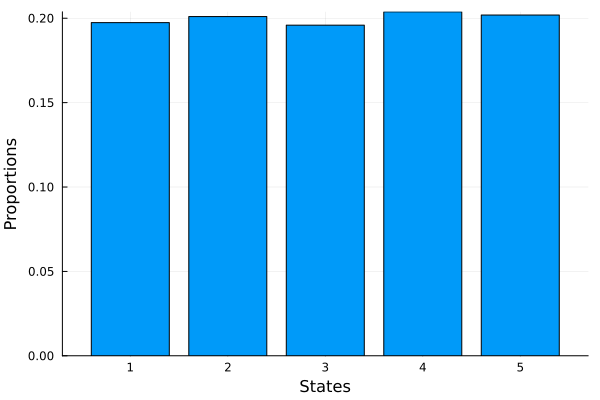

In [ ]:
states = collect(keys(proportions))  # Get the keys for the x-axis
state_proportions = collect(values(proportions))  # Get the values for the y-axis

bar(states, state_proportions, xlabel="States", ylabel="Proportions", legend=false)

In [ ]:
function L0_do_inference(model, stateProbs, utterance, m, amount_of_computation)

    observations = Gen.choicemap()
    observations[(:m)] = m
    (trace, _) = Gen.importance_resampling(model, (stateProbs, utterance), observations, amount_of_computation);

    return trace
end;

In [ ]:
Gen.get_choices(L0_do_inference(literalListener, stateProbs, "good", true, 100))

│
├── :m : true
│
└── :state : 4


In [ ]:
traces = [L0_do_inference(literalListener, stateProbs, "good", true, 100) for _=1:1000]
state_posterior = [trace[:state] for trace in traces]

counts = countmap(state_posterior)

total_samples = length(state_posterior)
proportions = Dict(state => count / total_samples for (state, count) in counts)

println(proportions)

Dict(5 => 0.384, 4 => 0.373, 2 => 0.022, 3 => 0.211, 1 => 0.01)


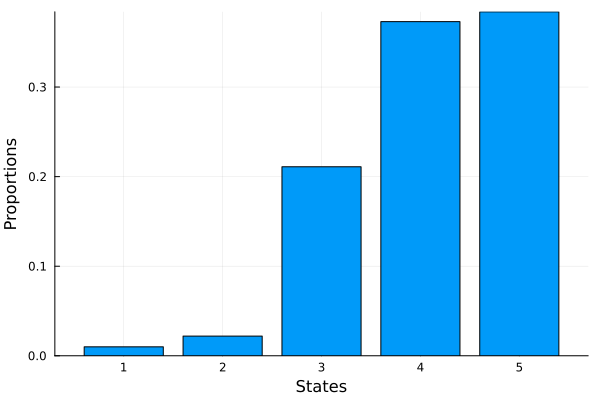

In [ ]:
states = collect(keys(proportions))  # Get the keys for the x-axis
state_proportions = collect(values(proportions))  # Get the values for the y-axis

bar(states, state_proportions, xlabel="States", ylabel="Proportions", legend=false)

### S1

In [ ]:
function L0_posterior(utter::Int64)

    traces = [L0_do_inference(literalListener, stateProbs, utterances[utter], true, 500) for _=1:10000]
    state_posterior = [trace[:state] for trace in traces]
    counts = countmap(state_posterior)
    total_samples = length(state_posterior)
    proportions = Dict(state => count / total_samples for (state, count) in counts)

    return proportions
end

L0_posterior_map = Dict(
    "terrible" => L0_posterior(1),
    "bad" => L0_posterior(2),
    "okay" => L0_posterior(3),
    "good" => L0_posterior(4),
    "amazing" => L0_posterior(5),
)

L0_posterior_mapped(utter::Int64) = L0_posterior_map[utterances[utter]]
L0_posterior_mapped(utter::String) = L0_posterior_map[utter]

get_utterance(utterIndex::Int64) = utterances[utterIndex]

lambda_ = 1.25
social(proportions::Dict, valueFunctionLambda) = sum(key * value for (key, value) in proportions) * valueFunctionLambda

@dist L0_utterance(utterIndex::Int64) = categorical(L0_posterior_mapped(get_utterance(utterIndex)))

@dist drawUtterance(utterancesProbs::Vector{Float64}) = utterances[categorical(utterancesProbs)]

state_logProb(L0_post::Dict, state::Int64) = log(L0_post[state])

L0_stateFunc(utterance::Int64) = [0, L0_posterior_mapped(utterance)]

@dist L0_state(utterance::Int64) = L0_stateFunc(utterance)[categorical([0, 1])]

Gen.CompiledDistWithArgs{Any}(Gen.WithLabelArg{Any, Int64}(Gen.Categorical()), 1, Bool[0], (Gen.TransformedArg{Any}(Gen.Arg[Gen.SimpleArg{Int64}(1)], L0_stateFunc, var"#304#305"()), [0, 1]))

In [ ]:
function S1_utility(state::Int64, utterance, phi::Float64)
    alpha_ = 10
    L0_post = L0_posterior_mapped(utterance)
    utility_epistemic = state_logProb(L0_post, state)
    utility_social = social(L0_post, lambda_)
    speakerUtility = phi * utility_epistemic + (1 - phi) * utility_social
    return alpha_ * speakerUtility
end

S1_utility (generic function with 1 method)

In [ ]:
@gen function speaker1(state::Int64, phi::Float64)

    utterance = @trace(drawUtterance(utterancesProbs), :utterance)
    L0_post = L0_posterior_mapped(utterance)

    function S1_utility(state::Int64, utterance, phi::Float64)
        alpha_ = 10
        L0_post = L0_posterior_mapped(utterance)
        utility_epistemic = state_logProb(L0_post, state)
        utility_social = social(L0_post, lambda_)
        speakerUtility = phi * utility_epistemic + (1 - phi) * utility_social
        return alpha_ * speakerUtility
    end

    utility = @trace(normal(S1_utility(state, utterance, phi), 1), :utility)

    return [utility, utterance]

end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##speaker1#369", Bool[0, 0], false)

In [ ]:
trace = Gen.simulate(speaker1, (4, 0.99))
trace[:utility]

-8.39474316446026

In [ ]:
Gen.get_choices(trace)

│
├── :utility : -7.909957064522746
│
└── :utterance : bad


In [ ]:
traces =[Gen.simulate(speaker1, (4, 0.99)) for _=1:1000]

trace_pl = [trace[:utterance] for trace in traces]

counts = countmap(trace_pl)

proportions = Dict(state => count / 1000 for (state, count) in counts)

println(proportions)

Dict("amazing" => 0.222, "okay" => 0.188, "terrible" => 0.203, "bad" => 0.202, "good" => 0.185)


In [ ]:
utils = Dict(state => (Dict(utterance => S1_utility(state, utterance, 0.99) for utterance in utterances)) for state in states)

Dict{Int64, Dict{String, Float64}} with 5 entries:
  5 => Dict("okay"=>-17.2987, "amazing"=>-4.93701, "terrible"=>-44.8192, "bad"=>-45.0031, "good"=>-…
  4 => Dict("okay"=>-11.6379, "amazing"=>-8.64946, "terrible"=>-44.9131, "bad"=>-44.9083, "good"=>-…
  2 => Dict("okay"=>-21.5685, "amazing"=>-43.9053, "terrible"=>-7.30707, "bad"=>-6.556, "good"=>-38…
  3 => Dict("okay"=>-8.13873, "amazing"=>-43.9053, "terrible"=>-46.4392, "bad"=>-45.3914, "good"=>-…
  1 => Dict("okay"=>-45.9789, "amazing"=>-45.4314, "terrible"=>-6.64335, "bad"=>-7.40851, "good"=>-…

In [ ]:
@gen function S1_do_inference(model, state::Int64, phi::Float64, utils::Dict, amount_of_computation)

    observations = Gen.choicemap()

    observe_sorted = [[utter, utils[state][utter]] for utter in utterances]

    for i in observe_sorted
        observations[:utility] = i[2]
    end
    (trace, _) = Gen.importance_resampling(model, (state, phi), observations, amount_of_computation)

    return trace
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Int64, Float64, Dict, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing], var"##S1_do_inference2#425", Bool[0, 0, 0, 0, 0], false)

In [ ]:
Gen.get_choices(S1_do_inference(speaker1, 4, 0.99, utils, 10))

│
├── :utility : -8.6494555571757
│
└── :utterance : amazing


In [ ]:
traces =[S1_do_inference(speaker1, 1, 0.99, utils, 100) for _=1:10000]

trace_pl = [trace[:utterance] for trace in traces]

counts = countmap(trace_pl)

proportions = Dict(utt => count / 10000 for (utt, count) in counts)

println(proportions)

Dict("okay" => 0.3371, "amazing" => 0.4019, "good" => 0.261)


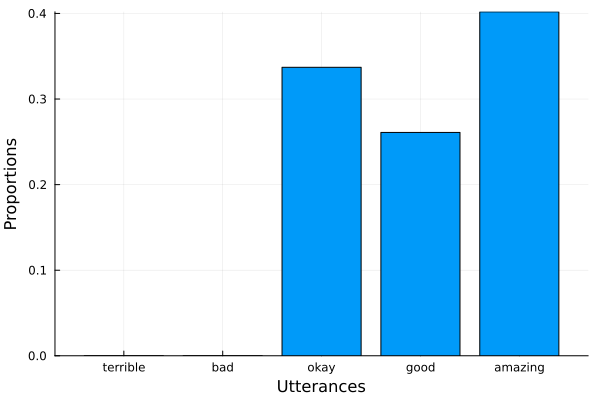

In [ ]:
all_utters = Dict((utter, 0.0) for utter in utterances)

for (utter, prop) in proportions
    if haskey(all_utters, utter)
        all_utters[utter] = prop
    end
end

utter_proportions = [all_utters[utter] for utter in utterances]

bar(utterances, utter_proportions, xlabel="Utterances", ylabel="Proportions", legend=false)

### L1

In [ ]:
function S1_posterior(state::Int64, phi::Float64)

    traces = [S1_do_inference(speaker1, state, phi, utils, 200) for _=1:5000]
    utter_posterior = [trace[:utterance] for trace in traces]
    counts = countmap(utter_posterior)
    total_samples = length(utter_posterior)
    incomplete_props = Dict(utter => count / total_samples for (utter, count) in counts)

    proportions = Dict((utter, 0.0) for utter in utterances)
    for (utter, prop) in incomplete_props
        if haskey(all_utters, utter)
            proportions[utter] = prop
        end
    end

    return proportions
end

phiVals = collect(0.05:0.05:0.95)
phiProbs = fill(1/length(phiVals), length(phiVals))

S1_posterior_map = Dict([state, phi] => S1_posterior(state, phi) for state in states for phi in phiVals)

S1_posterior_mapped(state::Int64, phi::Float64) = S1_posterior_map[[state, phi]]

S1_posterior_mapped (generic function with 2 methods)

In [ ]:
S1_posterior_map

Dict{Vector{Float64}, Dict{String, Float64}} with 95 entries:
  [1.0, 0.35] => Dict("okay"=>0.0, "amazing"=>0.0, "terrible"=>0.8758, "bad"=>0.1242, "good"=>0.0)
  [2.0, 0.6]  => Dict("okay"=>0.0, "amazing"=>1.0, "terrible"=>0.0, "bad"=>0.0, "good"=>0.0)
  [5.0, 0.5]  => Dict("okay"=>0.0, "amazing"=>0.0, "terrible"=>0.2318, "bad"=>0.7682, "good"=>0.0)
  [5.0, 0.55] => Dict("okay"=>0.0, "amazing"=>0.0, "terrible"=>0.2366, "bad"=>0.7634, "good"=>0.0)
  [3.0, 0.95] => Dict("okay"=>0.0, "amazing"=>0.0004, "terrible"=>0.6516, "bad"=>0.348, "good"=>0.0)
  [3.0, 0.3]  => Dict("okay"=>0.0, "amazing"=>0.0, "terrible"=>1.0, "bad"=>0.0, "good"=>0.0)
  [1.0, 0.2]  => Dict("okay"=>0.0, "amazing"=>0.0, "terrible"=>1.0, "bad"=>0.0, "good"=>0.0)
  [4.0, 0.95] => Dict("okay"=>0.8398, "amazing"=>0.0376, "terrible"=>0.0, "bad"=>0.0, "good"=>0.122…
  [4.0, 0.3]  => Dict("okay"=>0.0, "amazing"=>0.0, "terrible"=>0.9478, "bad"=>0.0522, "good"=>0.0)
  [2.0, 0.35] => Dict("okay"=>0.0, "amazing"=>0.0, "terrible"

In [ ]:
@dist S1_utter_post(state::Int64, phi::Float64) = normal(S1_posterior_mapped(state, phi), 1)
@dist phi_(phiProbs::Vector) = phiVals[categorical(phiProbs)]

Gen.CompiledDistWithArgs{Float64}(Gen.RelabeledDistribution{Float64, Int64}(Gen.Categorical(), [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]), 1, Bool[1], (Gen.SimpleArg{Vector}(1),))

In [ ]:
S1_posterior_mapped(1, 0.1)

Dict{String, Float64} with 5 entries:
  "okay"     => 0.0
  "amazing"  => 0.0
  "terrible" => 1.0
  "bad"      => 0.0
  "good"     => 0.0

In [ ]:
S1_utterFunc(state, phi) = [0, speaker1(state, phi)]

@dist S1_utter(state, phi) = S1_utterFunc(state, phi)[categorical([0, 1])]

Gen.CompiledDistWithArgs{Any}(Gen.WithLabelArg{Any, Int64}(Gen.Categorical()), 2, Bool[0, 0], (Gen.TransformedArg{Any}(Gen.Arg[Gen.SimpleArg{Any}(1), Gen.SimpleArg{Any}(2)], S1_utterFunc, var"#569#570"()), [0, 1]))

In [ ]:
S1_do_inference(speaker1, 1, 0.99, utils, 100)[:utterance]

"amazing"

In [ ]:
print(S1_do_inference(speaker1, 1, 0.99, utils, 100))

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##speaker1#406", Bool[0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:utility => Gen.ChoiceOrCallRecord{Float64}(-45.43141008703263, -0.9189385332046727, NaN, true), :utterance => Gen.ChoiceOrCallRecord{String}("amazing", -1.6094379124341003, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -2.5283764456387727, 0.0, (1, 0.99), "amazing")

In [ ]:
@gen _S1(state, phi) = S1_do_inference2(speaker1, state, phi, utils, 100)[:utterance]

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##_S1#434", Bool[0, 0], false)

In [ ]:
@gen save_S1(S1Dict, utterIndex::Int64) = collect(keys(S1Dict))[utterIndex]

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##save_S1#470", Bool[0, 0], false)

In [ ]:
@gen function pragmaticListener(utterance)

    state = @trace(Gen.categorical(stateProbs), :state)

    phi = @trace(phi_(phiProbs), :phi)

    S1Dict = S1_posterior_mapped(state, phi)

    S1 = @trace(Gen.categorical(collect(values(S1Dict))), :S1)

    return [state, phi]
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##pragmaticListener#472", Bool[0], false)

In [ ]:
trace = Gen.simulate(pragmaticListener, ("good", ))
Gen.get_choices(trace)

│
├── :S1 : 3
│
├── :state : 2
│
└── :phi : 0.1


In [ ]:
trace = L1_do_inference(pragmaticListener, ("good", ), 100)
Gen.get_choices(trace)

│
├── :S1 : 1
│
├── :state : 4
│
└── :phi : 0.85


In [ ]:
traces =[Gen.simulate(pragmaticListener, ("good", )) for _=1:1000000]

state_posterior1 = [trace[:state] for trace in traces]
state_posterior2 = [trace[:phi] for trace in traces]

counts1 = countmap(state_posterior1)
counts2 = countmap(state_posterior2)

total_samples1 = length(state_posterior1)
total_samples2 = length(state_posterior2)

proportions1 = Dict(state => count / total_samples1 for (state, count) in counts1)
proportions2 = Dict(state => count / total_samples2 for (state, count) in counts2)

println("state posterior: ", proportions1)
println("phi posterior: ", proportions2)

state posterior: Dict(5 => 0.200073, 4 => 0.199872, 2 => 0.200818, 3 => 0.199056, 1 => 0.200181)
phi posterior: Dict(0.95 => 0.052025, 0.3 => 0.052116, 0.45 => 0.052489, 0.25 => 0.052784, 0.35 => 0.052663, 0.7 => 0.052926, 0.85 => 0.052933, 0.15 => 0.052649, 0.2 => 0.05285, 0.9 => 0.052576, 0.65 => 0.052918, 0.8 => 0.052715, 0.05 => 0.053053, 0.5 => 0.052332, 0.55 => 0.052081, 0.1 => 0.052546, 0.4 => 0.052733, 0.75 => 0.052971, 0.6 => 0.05264)


In [ ]:
traces[1][:S1]

"bad"

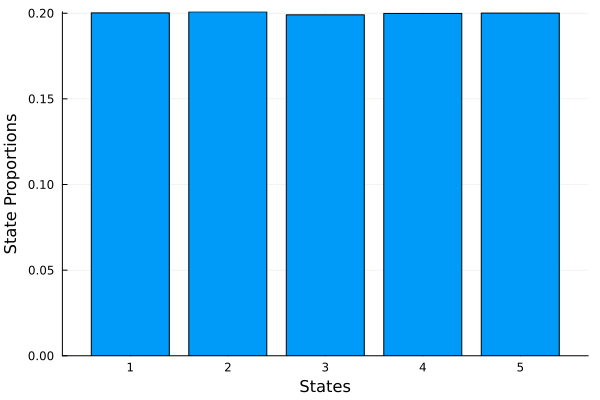

In [ ]:
states1 = collect(keys(proportions1))  # Get the keys for the x-axis
state_proportions1 = collect(values(proportions1))  # Get the values for the y-axis

bar(states1, state_proportions1, xlabel="States", ylabel="State Proportions", legend=false)

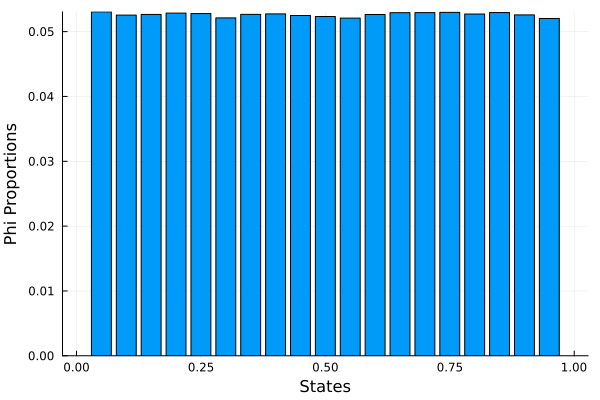

In [ ]:
states2 = collect(keys(proportions2))  # Get the keys for the x-axis
state_proportions2 = collect(values(proportions2))  # Get the values for the y-axis

bar(states2, state_proportions2, xlabel="States", ylabel="Phi Proportions", legend=false)

In [ ]:
function L1_do_inference(model, utterance, amount_of_computation)

    utter_map = Dict("okay"=>1, "amazing"=>2, "terrible"=>3, "bad"=>4, "good"=>5)

    observations = Gen.choicemap()
    observations[(:S1)] = utter_map[utterance]
    (trace, _) = Gen.importance_resampling(model, (utterance, ), observations, amount_of_computation);

    return trace
end;

In [ ]:
pragmaticListener("good")

2-element Vector{Float64}:
 4.0
 0.7

In [ ]:
trace = L1_do_inference(pragmaticListener, "good", 1)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##pragmaticListener#472", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:S1 => Gen.ChoiceOrCallRecord{Int64}(5, -Inf, NaN, true), :state => Gen.ChoiceOrCallRecord{Int64}(3, -1.6094379124341003, NaN, true), :phi => Gen.ChoiceOrCallRecord{Float64}(0.15, -2.9444389791664407, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -Inf, 0.0, ("good",), [3.0, 0.15])

In [ ]:
traces =[L1_do_inference(pragmaticListener, "bad", 100) for _=1:100000]

state_posterior1 = [trace[:state] for trace in traces]
state_posterior2 = [trace[:phi] for trace in traces]

counts1 = countmap(state_posterior1)
counts2 = countmap(state_posterior2)

total_samples1 = length(state_posterior1)
total_samples2 = length(state_posterior2)

proportions1 = Dict(state => count / total_samples1 for (state, count) in counts1)
proportions2 = Dict(state => count / total_samples2 for (state, count) in counts2)

println("state posterior: ", proportions1)
println("phi posterior: ", proportions2)

state posterior: Dict(5 => 0.41408, 4 => 0.5242, 3 => 0.04502, 1 => 0.0167)
phi posterior: Dict(0.95 => 0.04214, 0.3 => 0.03352, 0.45 => 0.14755, 0.25 => 0.01096, 0.35 => 0.08349, 0.85 => 0.00026, 0.15 => 0.00075, 0.2 => 0.00234, 0.9 => 0.00262, 0.65 => 0.10278, 0.5 => 0.17502, 0.55 => 0.18603, 0.1 => 0.00015, 0.4 => 0.11043, 0.6 => 0.10196)


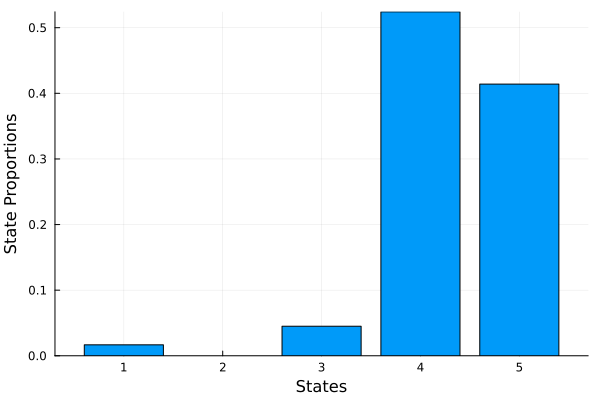

In [ ]:
states1 = collect(keys(proportions1))  # Get the keys for the x-axis
state_proportions1 = collect(values(proportions1))  # Get the values for the y-axis

bar(states1, state_proportions1, xlabel="States", ylabel="State Proportions", legend=false)

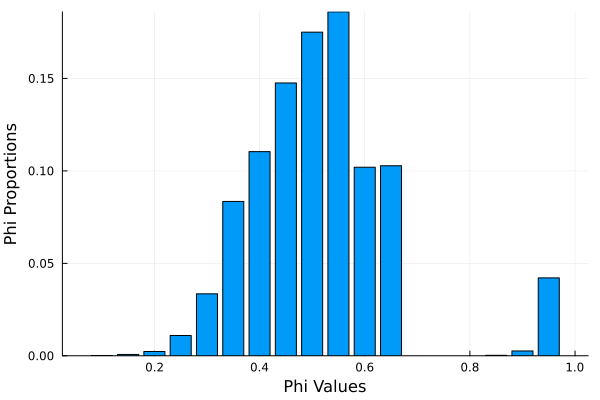

In [ ]:
phi_num = collect(keys(proportions2))  # Get the keys for the x-axis
phi_proportions = collect(values(proportions2))  # Get the values for the y-axis

bar(phi_num, phi_proportions, xlabel="Phi Values", ylabel="Phi Proportions", legend=false)

## Politeness with indirect speech acts

### L0

In [ ]:
utterances = [
  "yes_terrible","yes_bad","yes_good","yes_amazing",
  "not_terrible","not_bad","not_good","not_amazing"
]
utterancesProbs = [1/8, 1/8, 1/8, 1/8,
                   1/8, 1/8, 1/8, 1/8]
states = [0,1,2,3]
stateProbs = [0.25, 0.25, 0.25, 0.25]

function isNegation(utt)
    return (split(utt, "_")[1] == "not")
end

cost_yes = 0;
cost_neg = 0.35
speakerOptimality = 4
speakerOptimality2 = 4

function roundToTwo(x)
    return round(x, digits=2)
end

weightBins = round.(range(0, stop=1, step=0.05), digits=2)

phiWeights = repeat([1/length(weightBins)], length(weightBins))

function cost(utterance)
    return isNegation(utterance) ? cost_neg : cost_yes
end

literalSemantics = Dict(
  "state"=> [0, 1, 2, 3],
  "not_amazing"=> [0.9652,0.9857,0.7873,0.0018],
  "not_bad"=> [0.0967,0.365,0.7597,0.9174],
  "not_good"=> [0.9909,0.736,0.2552,0.2228],
  "not_terrible"=> [0.2749,0.5285,0.728,0.9203],
  "yes_amazing"=> [4e-04,2e-04,0.1048,0.9788 ],
  "yes_bad"=> [0.9999,0.8777,0.1759,0.005],
  "yes_good"=> [0.0145,0.1126,0.9893,0.9999],
  "yes_terrible"=> [0.9999,0.3142,0.0708,0.0198]
)

prob(utterance::String, state::Int64) = literalSemantics[utterance][state]

@dist meaning(utterance::String, state::Int64) =  bernoulli(prob(utterance, state))

Gen.CompiledDistWithArgs{Bool}(Gen.Bernoulli(), 2, Bool[1, 1], (Gen.TransformedArg{Any}(Gen.Arg[Gen.SimpleArg{String}(1), Gen.SimpleArg{Int64}(2)], prob, var"#228#229"()),))

In [ ]:
@dist state_sample(stateProbs) = categorical(stateProbs)-1

Gen.CompiledDistWithArgs{Int64}(Gen.TransformedDistribution{Int64, Int64}(Gen.Categorical(), 0, Gen.var"#76#79"{Int64}(-1), Gen.var"#77#80"{Int64}(-1), Gen.var"#78#81"()), 1, Bool[1], (Gen.SimpleArg{Any}(1),))

In [ ]:
@gen function literalListener(stateProbs::Vector{Float64}, utterance::String)

    state = @trace(state_sample(stateProbs), :state) + 1

    m = @trace(meaning(utterance, state), :m)

    return state

end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Float64}, String], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##literalListener#360", Bool[0, 0], false)

In [ ]:
function L0_do_inference(model, stateProbs, utterance, m, amount_of_computation)

    observations = Gen.choicemap()
    observations[(:m)] = m
    (trace, _) = Gen.importance_resampling(model, (stateProbs, utterance), observations, amount_of_computation);

    return trace
end;

In [ ]:
traces = [L0_do_inference(literalListener, stateProbs, "not_amazing", true, 100) for _=1:10000]
state_posterior = [trace[:state] for trace in traces]

counts = countmap(state_posterior)

total_samples = length(state_posterior)
proportions = Dict(state => count / total_samples for (state, count) in counts)

println(proportions)

Dict(0 => 0.3528, 2 => 0.2865, 3 => 0.0007, 1 => 0.36)


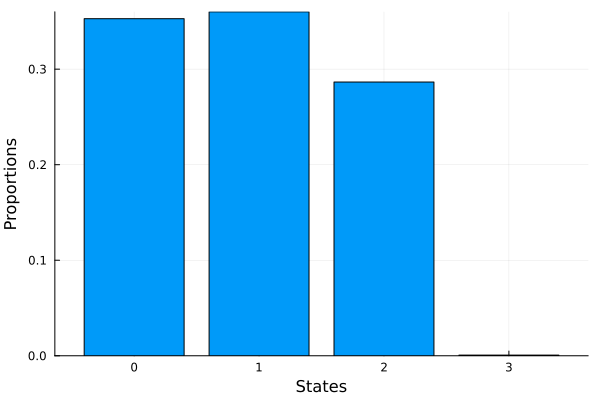

In [ ]:
all_states = Dict((state, 0.0) for state in states)

for (state, prop) in proportions
    if haskey(all_states, state)
        all_states[state] = prop
    end
end

state_proportions = [all_states[state] for state in states]

bar(states, state_proportions, xlabel="States", ylabel="Proportions", legend=false)

### S1

In [ ]:
function L0_posterior(utter::Int64)

    traces = [L0_do_inference(literalListener, stateProbs, utterances[utter], true, 500) for _=1:10000]
    state_posterior = [trace[:state] for trace in traces]
    counts = countmap(state_posterior)
    total_samples = length(state_posterior)
    proportions = Dict(state => count / total_samples for (state, count) in counts)

    return proportions
end

L0_posterior_map = Dict(
  "yes_terrible"=> L0_posterior(1),
  "yes_bad"=> L0_posterior(2),
  "yes_good"=> L0_posterior(3),
  "yes_amazing"=> L0_posterior(4),
  "not_terrible"=> L0_posterior(5),
  "not_bad"=> L0_posterior(6),
  "not_good"=> L0_posterior(7),
  "not_amazing"=> L0_posterior(8)
)

L0_posterior_mapped(utter::Int64) = L0_posterior_map[utterances[utter]]
L0_posterior_mapped(utter::String) = L0_posterior_map[utter]

get_utterance(utterIndex::Int64) = utterances[utterIndex]

lambda_ = 1.25
social(proportions::Dict, valueFunctionLambda) = sum(key * value for (key, value) in proportions) * valueFunctionLambda

@dist L0_utterance(utterIndex::Int64) = categorical(L0_posterior_mapped(get_utterance(utterIndex)))

@dist drawUtterance(utterancesProbs::Vector{Float64}) = categorical(utterancesProbs)

Gen.CompiledDistWithArgs{Int64}(Gen.Categorical(), 1, Bool[1], (Gen.SimpleArg{Vector{Float64}}(1),))

In [ ]:
state_logProb(L0_post::Dict, state::Int64) = log(L0_post[state])

L0_stateFunc(utterance::Int64) = [0, L0_posterior_mapped(utterance)]

@dist L0_state(utterance::Int64) = L0_stateFunc(utterance)[categorical([0, 1])]

function S1_utility(state::Int64, utterance, phi::Float64)
    L0_post = L0_posterior_mapped(utterance)
    utility_epistemic = state_logProb(L0_post, state)
    utility_social = social(L0_post, lambda_)
    speakerUtility = phi * utility_epistemic + (1 - phi) * utility_social - cost(utterance)
    return speakerOptimality * speakerUtility
end

S1_utility (generic function with 1 method)

In [ ]:
@gen function speaker1(state::Int64, phi::Float64)

    utterance = @trace(drawUtterance(utterancesProbs), :utterance)
    L0_post = L0_posterior_mapped(utterance)

    function S1_utility(state::Int64, utterance, phi::Float64)
        L0_post = L0_posterior_mapped(utterance)
        utility_epistemic = state_logProb(L0_post, state)
        utility_social = social(L0_post, lambda_)
        speakerUtility = phi * utility_epistemic + (1 - phi) * utility_social - cost(utterances[utterance])
        return speakerOptimality * speakerUtility
    end

    utility = @trace(normal(S1_utility(state, utterance, phi), 1), :utility)
    return [utility, utterance]

end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##speaker1#363", Bool[0, 0], false)

In [ ]:
utils = Dict(state => (Dict(utterance => S1_utility(state, utterance, 0.99) for utterance in utterances)) for state in states)

Dict{Int64, Dict{String, Float64}} with 4 entries:
  0 => Dict("not_bad"=>-13.8072, "yes_amazing"=>-29.9546, "yes_terrible"=>-1.30756, "not_good"=>-4.…
  2 => Dict("not_bad"=>-5.40906, "yes_amazing"=>-9.03711, "yes_terrible"=>-11.7743, "not_good"=>-10…
  3 => Dict("not_bad"=>-4.60758, "yes_amazing"=>-0.267835, "yes_terrible"=>-16.9717, "not_good"=>-1…
  1 => Dict("not_bad"=>-8.27795, "yes_amazing"=>-36.328, "yes_terrible"=>-5.97961, "not_good"=>-5.7…

In [ ]:
@gen function S1_do_inference3(model, state::Int64, phi::Float64, utils::Dict, amount_of_computation)

    observations = Gen.choicemap()

    observe_sorted = [[utter, utils[state][utter]] for utter in utterances]

    for i in observe_sorted
        observations[:utility] = i[2]
    end
    (trace, _) = Gen.importance_resampling(model, (state, phi), observations, amount_of_computation)

    return trace
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Int64, Float64, Dict, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing], var"##S1_do_inference3#355", Bool[0, 0, 0, 0, 0], false)

In [ ]:
Gen.get_choices(S1_do_inference3(speaker1, 1, 0.99, utils, 100))

│
├── :utility : -5.315247047072646
│
└── :utterance : 1


In [ ]:
traces =[S1_do_inference3(speaker1, 1, 0.99, utils, 100) for _=1:10000]

trace_pl = [trace[:utterance] for trace in traces]

counts = countmap(trace_pl)

proportions = Dict(utt => count / 10000 for (utt, count) in counts)

println(proportions)

Dict(5 => 0.0492, 6 => 0.0042, 7 => 0.2979, 2 => 0.0502, 8 => 0.3262, 1 => 0.2723)


In [ ]:
proportions

Dict{Int64, Float64} with 6 entries:
  5 => 0.0492
  6 => 0.0042
  7 => 0.2979
  2 => 0.0502
  8 => 0.3262
  1 => 0.2723

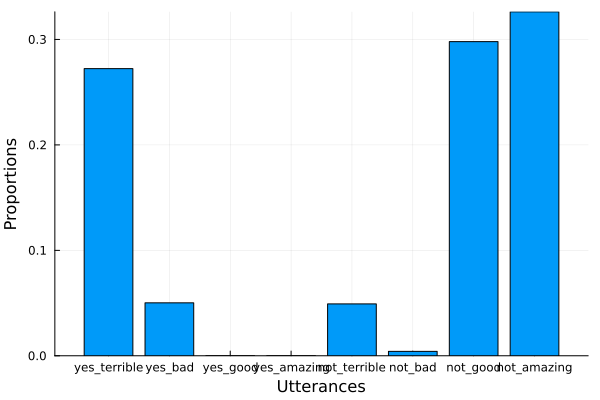

In [ ]:
all_utters = Dict((utter, 0.0) for utter in utterances)

for (utter, prop) in proportions
    all_utters[utterances[utter]] = prop
end

utter_proportions = [all_utters[utter] for utter in utterances]

bar(utterances, utter_proportions, xlabel="Utterances", ylabel="Proportions", legend=false)

### L1

In [ ]:
function S1_posterior(state::Int64, phi::Float64)

    traces = [S1_do_inference3(speaker1, state, phi, utils, 200) for _=1:5000]
    utter_posterior = [trace[:utterance] for trace in traces]
    counts = countmap(utter_posterior)
    total_samples = length(utter_posterior)
    incomplete_props = Dict(utter => count / total_samples for (utter, count) in counts)

    proportions = Dict((utter, 0.0) for utter in utterances)
    for (utter, prop) in incomplete_props
        proportions[utterances[utter]] = prop
    end

    return proportions
end

S1_posterior_map = Dict([state, phi] => S1_posterior(state, phi) for state in states for phi in weightBins)

S1_posterior_mapped(state::Int64, phi::Float64) = S1_posterior_map[[state, phi]]

S1_posterior_mapped (generic function with 1 method)

In [ ]:
S1_posterior_map

Dict{Vector{Float64}, Dict{String, Float64}} with 84 entries:
  [0.0, 0.7]  => Dict("not_bad"=>0.3144, "yes_amazing"=>0.0, "yes_terrible"=>0.0, "not_good"=>0.004…
  [1.0, 0.35] => Dict("not_bad"=>0.0, "yes_amazing"=>0.999, "yes_terrible"=>0.001, "not_good"=>0.0,…
  [2.0, 0.6]  => Dict("not_bad"=>0.0, "yes_amazing"=>0.0, "yes_terrible"=>0.6288, "not_good"=>0.238…
  [3.0, 0.95] => Dict("not_bad"=>0.0, "yes_amazing"=>0.0, "yes_terrible"=>0.0, "not_good"=>0.0, "ye…
  [3.0, 0.3]  => Dict("not_bad"=>0.0, "yes_amazing"=>0.0, "yes_terrible"=>0.0, "not_good"=>0.0, "ye…
  [1.0, 0.2]  => Dict("not_bad"=>0.0, "yes_amazing"=>0.0, "yes_terrible"=>0.9956, "not_good"=>0.004…
  [2.0, 0.35] => Dict("not_bad"=>0.0, "yes_amazing"=>0.0, "yes_terrible"=>0.9922, "not_good"=>0.006…
  [1.0, 0.05] => Dict("not_bad"=>0.0, "yes_amazing"=>0.0, "yes_terrible"=>0.9996, "not_good"=>0.000…
  [3.0, 0.7]  => Dict("not_bad"=>0.0, "yes_amazing"=>0.0, "yes_terrible"=>0.0, "not_good"=>0.0, "ye…
  [2.0, 0.2]  => Dict("not_ba

In [ ]:
@dist phi_(phiWeights::Vector) = weightBins[categorical(phiWeights)]

Gen.CompiledDistWithArgs{Float64}(Gen.RelabeledDistribution{Float64, Int64}(Gen.Categorical(), [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45  …  0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]), 1, Bool[1], (Gen.SimpleArg{Vector}(1),))

In [ ]:
@gen function pragmaticListener(utterance)

    state = @trace(state_sample(stateProbs), :state) + 1

    phi = @trace(phi_(phiWeights), :phi)

    S1Dict = S1_posterior_mapped(state-1, phi)

    S1 = @trace(Gen.categorical(collect(values(S1Dict))), :S1)

    return [state, phi]
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##pragmaticListener#370", Bool[0], false)

In [ ]:
function L1_do_inference(model, utterance, amount_of_computation)

    utter_map = Dict("not_bad"=> 1,
                     "yes_amazing"=>2,
                     "yes_terrible"=>3,
                     "not_good"=>4,
                     "yes_good"=>5,
                     "yes_bad"=>6,
                     "not_terrible"=>7,
                     "not_amazing"=>8)

    observations = Gen.choicemap()
    observations[(:S1)] = utter_map[utterance]
    (trace, _) = Gen.importance_resampling(model, (utterance, ), observations, amount_of_computation);

    return trace
end;

In [ ]:
traces =[L1_do_inference(pragmaticListener, "not_bad", 100) for _=1:100000]

state_posterior1 = [trace[:state] for trace in traces]
state_posterior2 = [trace[:phi] for trace in traces]

counts1 = countmap(state_posterior1)
counts2 = countmap(state_posterior2)

total_samples1 = length(state_posterior1)
total_samples2 = length(state_posterior2)

proportions1 = Dict(state => count / total_samples1 for (state, count) in counts1)
proportions2 = Dict(state => count / total_samples2 for (state, count) in counts2)

println("state posterior: ", proportions1)
println("phi posterior: ", proportions2)

state posterior: Dict(0 => 0.57342, 2 => 0.14151, 1 => 0.28507)
phi posterior: Dict(0.95 => 0.04993, 1.0 => 0.08567, 0.7 => 0.12473, 0.85 => 0.07058, 0.9 => 0.04431, 0.65 => 0.22754, 0.8 => 0.08695, 0.5 => 0.00404, 0.55 => 0.03511, 0.75 => 0.0626, 0.6 => 0.20854)


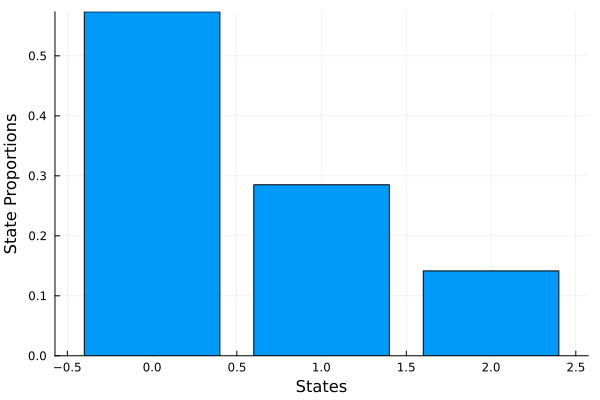

In [ ]:
states1 = collect(keys(proportions1))  # Get the keys for the x-axis
state_proportions1 = collect(values(proportions1))  # Get the values for the y-axis

bar(states1, state_proportions1, xlabel="States", ylabel="State Proportions", legend=false)

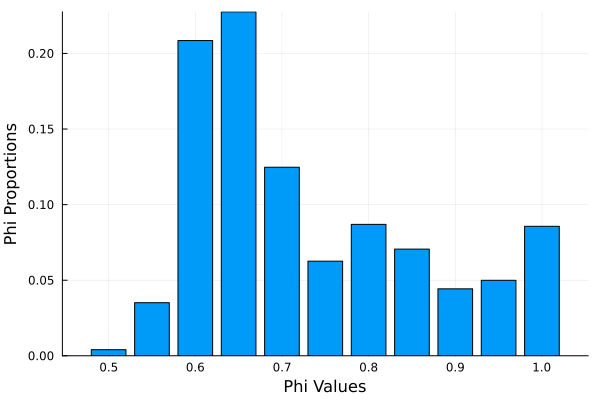

In [ ]:
phi_num = collect(keys(proportions2))  # Get the keys for the x-axis
phi_proportions = collect(values(proportions2))  # Get the values for the y-axis

bar(phi_num, phi_proportions, xlabel="Phi Values", ylabel="Phi Proportions", legend=false)

### S2

In [ ]:
function L1_posterior(utter::Int64)

    traces = [L1_do_inference(pragmaticListener, utterances[utter], 100) for _=1:10000]

    state_posterior = [trace[:state] for trace in traces]
    phi_posterior = [trace[:phi] for trace in traces]

    countState = countmap(state_posterior)
    countPhi = countmap(phi_posterior)

    total_samples_state = length(state_posterior)
    total_samples_phi = length(phi_posterior)

    state_incomplete_props = Dict(state => count / total_samples_state for (state, count) in countState)
    phi_incomplete_props = Dict(state => count / total_samples_phi for (state, count) in countPhi)

    proportions_state = Dict((state, 0.0) for state in states)
    for (state, prop) in state_incomplete_props
        proportions_state[state] = prop
    end

    proportions_phi = Dict((phi, 0.0) for phi in weightBins)
    for (phi, prop) in phi_incomplete_props
        proportions_phi[phi] = prop
    end

    return [proportions_state, proportions_phi]
end

s1, p1 = L1_posterior(1); s2, p2 = L1_posterior(2); s3, p3 = L1_posterior(3); s4, p4 = L1_posterior(4)
s5, p5 = L1_posterior(5); s6, p6 = L1_posterior(6); s7, p7 = L1_posterior(7); s8, p8 = L1_posterior(8)

L1_posterior_map_state = Dict("yes_terrible"=>s1,"yes_bad"=>s2,"yes_good"=>s3,"yes_amazing"=>s4,
                              "not_terrible"=>s5,"not_bad"=>s6,"not_good"=>s7,"not_amazing"=> s8)
L1_posterior_map_phi = Dict("yes_terrible"=>p1,"yes_bad"=>p2,"yes_good"=>p3,"yes_amazing"=>p4,
                            "not_terrible"=>p5,"not_bad"=>p6,"not_good"=>p7,"not_amazing"=>p8)

L1_posterior_mapped_state(utter::Int64) = L1_posterior_map_state[utterances[utter]]
L1_posterior_mapped_state(utter::String) = L1_posterior_map_state[utter]
L1_posterior_mapped_phi(utter::Int64) = L1_posterior_map_phi[utterances[utter]]
L1_posterior_mapped_phi(utter::String) = L1_posterior_map_phi[utter]

get_utterance(utterIndex::Int64) = utterances[utterIndex]

lambda_ = 1.25
social(proportions::Dict, valueFunctionLambda) = sum(key * value for (key, value) in proportions) * valueFunctionLambda

@dist L0_utterance_state(utterIndex::Int64) = categorical(L1_posterior_mapped_state(utterIndex))
@dist L0_utterance_phi(utterIndex::Int64) = categorical(L1_posterior_mapped_phi(utterIndex))
@dist drawUtterance(utterancesProbs::Vector{Float64}) = categorical(utterancesProbs)

Gen.CompiledDistWithArgs{Int64}(Gen.Categorical(), 1, Bool[1], (Gen.SimpleArg{Vector{Float64}}(1),))

In [ ]:
L1_posterior_map_state

Dict{String, Dict{Int64, Float64}} with 8 entries:
  "not_bad"      => Dict(0=>0.5665, 2=>0.1439, 3=>0.0, 1=>0.2896)
  "yes_amazing"  => Dict(0=>0.3975, 2=>0.1481, 3=>0.0, 1=>0.4544)
  "yes_terrible" => Dict(0=>0.1706, 2=>0.4186, 3=>0.0641, 1=>0.3467)
  "not_good"     => Dict(0=>0.3363, 2=>0.3431, 3=>0.0, 1=>0.3206)
  "yes_good"     => Dict(0=>0.5464, 2=>0.0013, 3=>0.0, 1=>0.4523)
  "yes_bad"      => Dict(0=>0.0324, 2=>0.9069, 3=>0.0, 1=>0.0607)
  "not_terrible" => Dict(0=>0.5766, 2=>0.2078, 3=>0.0, 1=>0.2156)
  "not_amazing"  => Dict(0=>0.1585, 2=>0.057, 3=>0.7357, 1=>0.0488)

In [ ]:
L1_posterior_map_phi

Dict{String, Dict{Float64, Float64}} with 8 entries:
  "not_bad"      => Dict(0.8=>0.0877, 0.95=>0.0502, 0.3=>0.0, 0.5=>0.0045, 0.55=>0.0344, 0.1=>0.0, …
  "yes_amazing"  => Dict(0.8=>0.0165, 0.95=>0.0135, 0.3=>0.1097, 0.5=>0.0185, 0.55=>0.0, 0.1=>0.0, …
  "yes_terrible" => Dict(0.8=>0.0063, 0.95=>0.0079, 0.3=>0.0376, 0.5=>0.0581, 0.55=>0.054, 0.1=>0.0…
  "not_good"     => Dict(0.8=>0.0737, 0.95=>0.103, 0.3=>0.0618, 0.5=>0.0267, 0.55=>0.0454, 0.1=>0.0…
  "yes_good"     => Dict(0.8=>0.0385, 0.95=>0.0, 0.3=>0.0, 0.5=>0.2341, 0.55=>0.239, 0.1=>0.0, 0.45…
  "yes_bad"      => Dict(0.8=>0.1893, 0.95=>0.0265, 0.3=>0.0031, 0.5=>0.012, 0.55=>0.0245, 0.1=>0.0…
  "not_terrible" => Dict(0.8=>0.1902, 0.95=>0.108, 0.3=>0.0, 0.5=>0.0, 0.55=>0.0006, 0.1=>0.0, 0.45…
  "not_amazing"  => Dict(0.8=>0.0514, 0.95=>0.0886, 0.3=>0.0583, 0.5=>0.041, 0.55=>0.0416, 0.1=>0.0…

In [ ]:
@gen function speaker2(state::Int64, phi::Float64, weights::Dict)

    utterance = @trace(drawUtterance(utterancesProbs), :utterance)

    function S2_utility(state::Int64, utterance, phi::Float64, weights::Dict)
        L1_state = L1_posterior_mapped_state(utterance)
        L1_phi = L1_posterior_mapped_phi(utterance)
        utilities_epistemic = state_logProb(L1_state, state)
        utilities_social = social(L1_state, lambda_)
        utilities_presentational = social(L1_phi, lambda_)
        speakerUtility = weights["inf"] * utilities_epistemic + weights["soc"] * utilities_social + weights["pres"] * utilities_presentational
        return speakerOptimality2 * speakerUtility
    end

    utility = @trace(normal(S2_utility(state, utterance, phi, weights), 1), :utility)

    return utterances[utterance]

end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Float64, Dict], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##speaker2#399", Bool[0, 0, 0], false)

In [ ]:
speaker2(0, 0.35, Dict("soc"=> 0.30, "pres"=> 0.45, "inf"=> 0.25))

"yes_terrible"

In [ ]:
@gen function S2_do_inference(model, state::Int64, phi::Float64, weights::Dict, amount_of_computation)

    function S2_utility(state::Int64, utterance, phi::Float64, weights::Dict)
        L1_state = L1_posterior_mapped_state(utterance)
        L1_phi = L1_posterior_mapped_phi(utterance)
        utilities_epistemic = state_logProb(L1_state, state)
        utilities_social = social(L1_state, lambda_)
        utilities_presentational = social(L1_phi, lambda_)
        speakerUtility = weights["inf"] * utilities_epistemic + weights["soc"] * utilities_social + weights["pres"] * utilities_presentational
        return speakerOptimality2 * speakerUtility
    end

    observations = Gen.choicemap()

    observe_sorted = [[utter, S2_utility(state, utter, phi, weights)] for utter in utterances]
    # state_map = Dict(0 => 1, 2 => 2, 3 => 3, 1 => 4)
    # phi_map = Dict(0.8=>1, 0.95=>2, 0.3=>3, 0.5=>4, 0.55=>5, 0.1=>6, 0.45=>7, 0.25=>8, 0.35=>9, 1.0=>10,
    #                0.7=>11, 0.0=>12, 0.4=>13, 0.85=>14, 0.15=>15,0.2=>16, 0.9=>17, 0.65=>18, 0.75=>19, 0.05=>20, 0.6=>21)

    for i in observe_sorted
        observations[(:utility)] = i[2]
    end
    (trace, _) = Gen.importance_resampling(model, (state, phi, weights), observations, amount_of_computation)

    return trace
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Int64, Float64, Dict, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing], var"##S2_do_inference#401", Bool[0, 0, 0, 0, 0], false)

In [ ]:
traces =[S2_do_inference(speaker2, 0, 0.35, Dict("soc"=> 0.30, "pres"=> 0.45, "inf"=> 0.25), 100) for _=1:10000]

trace_pl = [trace[:utterance] for trace in traces]

counts = countmap(trace_pl)

proportions = Dict(utt => count / 10000 for (utt, count) in counts)

println(proportions)

Dict(5 => 0.2066, 4 => 0.0506, 6 => 0.1487, 7 => 0.1622, 2 => 0.0402, 8 => 0.2869, 3 => 0.0794, 1 => 0.0254)


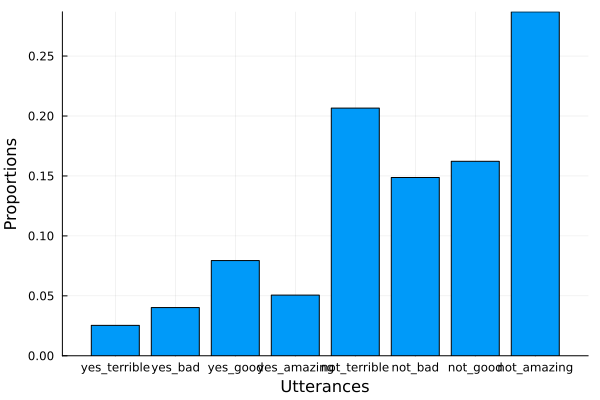

In [ ]:
all_utters = Dict((utter, 0.0) for utter in utterances)

for (utter, prop) in proportions
    all_utters[utterances[utter]] = prop
end

utter_proportions = [all_utters[utter] for utter in utterances]

bar(utterances, utter_proportions, xlabel="Utterances", ylabel="Proportions", legend=false)